In [2]:
import pyspark
from pyspark import SparkContext as sc
from pyspark import SparkConf
import numpy as np
from pyspark.sql import types as T, SparkSession
# from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial import KDTree
conf=SparkConf().setAppName("DBSCAN").setMaster("local[*]")
sc=sc.getOrCreate(conf)

In [3]:
def parseVector(line):
    return np.array([float(x) for x in line.split()])

In [4]:
def nearest_neighbour(iterator):
    k_tree = kd.value
    for p in iterator:
        # query the index for itself
        index_p = k_tree.query_ball_point(p, 0)
        neighbour = k_tree.query_ball_point(p, min_dis)
        yield list((index_p, (neighbour, len(neighbour) - 1)))

In [5]:
def load_point(path):
    points = sc.textFile(path).map(lambda x: x.strip().split()[:]).map(lambda x: tuple([float(i) for i in x]))
    return points.collect()

In [6]:
def plain_picture(fileName, ax):
    # draw original plot
    X = np.array(load_point(fileName))
#     labels_true = np.array(load_label(fileName))
    
    ax[0].plot(X[:, 0], X[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
                 markeredgecolor='k', markersize=3, scalex=1, scaley=1)
    ax[0].set_title('plot of '+fileName[8:-4])
    return X

In [7]:
def processed_picture(X, ax, N, labelList,fileName):
    N += 1

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    bounds = np.linspace(0,N,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,6))
    scat = ax[1].scatter([i[0] for i in X],[i[1] for i in X],c=labelList,s=None,cmap=cmap,norm=norm)
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label('Custom cbar')
    ax[1].set_title('DBSCAN Result of '+fileName[8:-4])
    plt.show()

In [8]:
import time

kdtree run time on spiral.txt: 1.1017491817474365
[0, 106, 207]


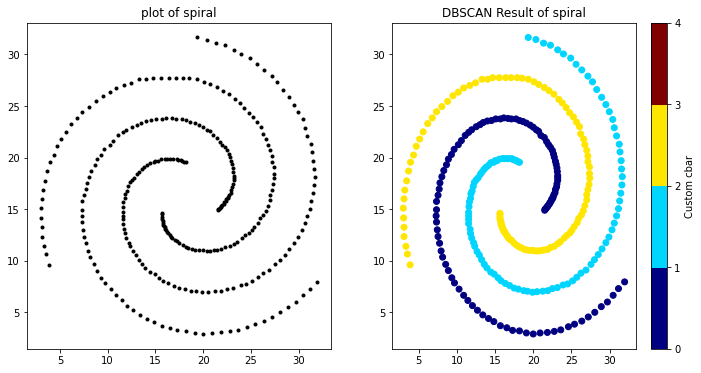

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/spiral.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 10)
min_dis = 3.6
min_point = 2

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on spiral.txt:', end_time - start_time)
print(label_set)

processed_picture(X,ax,len(label_set),labelList,fileName)

kdtree run time on flame.txt: 0.4141719341278076


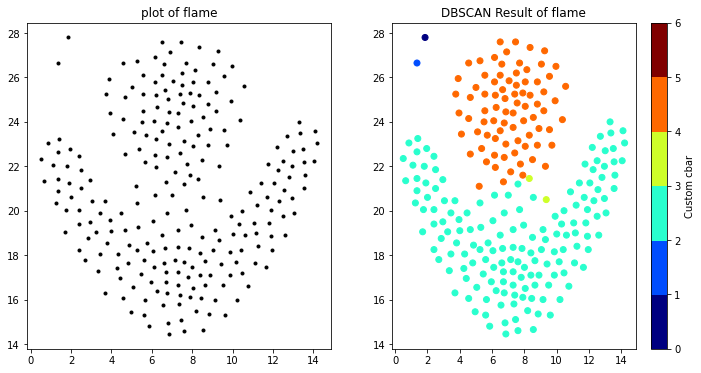

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/flame.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 1.35
min_point = 5

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on flame.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

kdtree run time on R15.txt: 1.6739625930786133


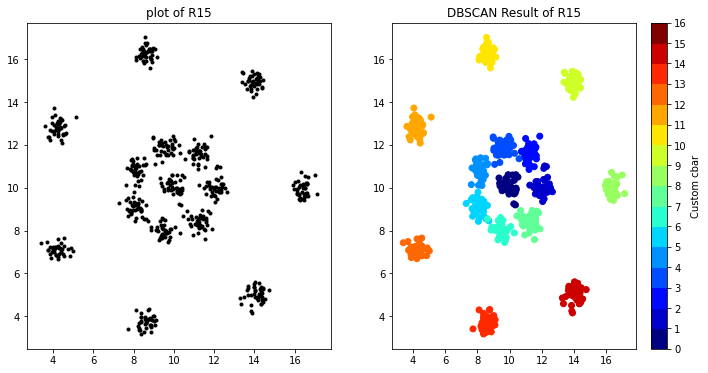

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/R15.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 0.7
min_point = 12

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

kdtree run time on R15.txt: 16.67220115661621


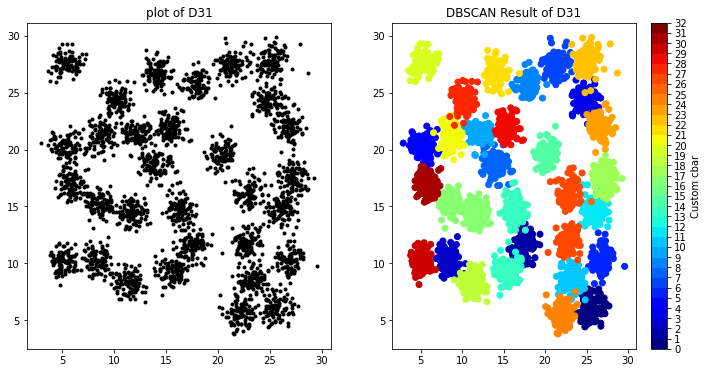

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/D31.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 1.7
min_point = 6

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

kdtree run time on R15.txt: 15.350500345230103


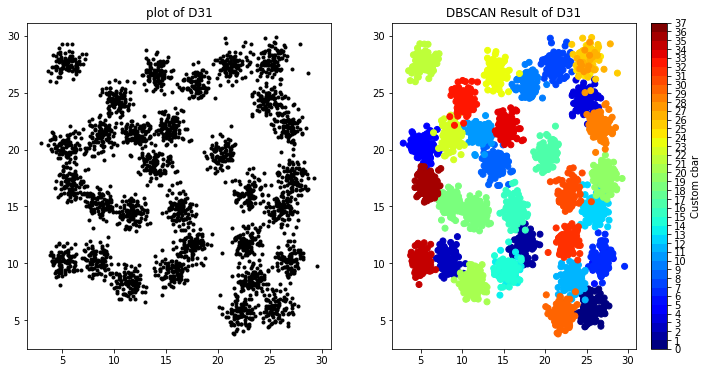

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/D31.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 10)
min_dis = 1.4
min_point = 8

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

kdtree run time on R15.txt: 130.0328414440155


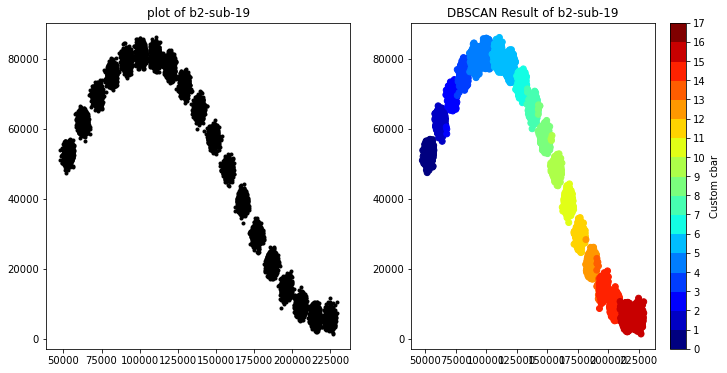

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/b2-sub-19.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 2000
min_point = 5

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

kdtree run time on R15.txt: 31.737853288650513


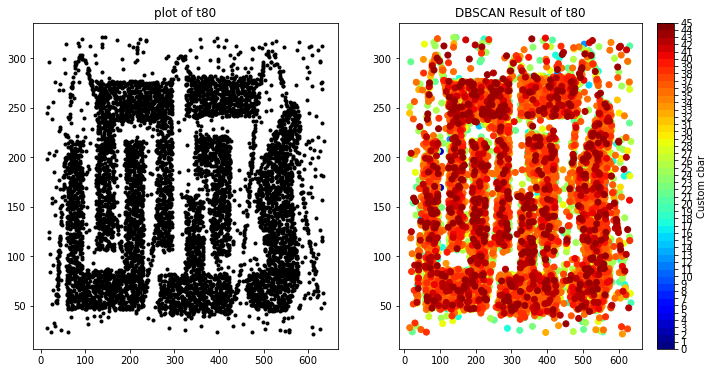

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/t80.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 20
min_point = 4

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
fileName = 'dataset/t80.txt'
X = plain_picture(fileName,ax)

start_time = time.time()

lines = sc.textFile(fileName, 5)
min_dis = 20
min_point = 4

data = lines.map(parseVector).cache()  # data is an RDD of arrays

data_broad = data.collect()
kd_tree = KDTree(data_broad)

# since the kd_tree return the index, put the index as id, this dict just for easy looking
dict_data = {}

for i in range(len(data_broad)):
    dict_data[i] = data_broad[i]

#     print(dict_data)
# N = kd_tree.query_ball_point(data_broad[0], min_dis)
# print(N)

kd = sc.broadcast(kd_tree)

# reduce O(n) to O(n/p)
neighbourhood = data.mapPartitions(nearest_neighbour).cache()
# print(neighbourhood.collect())

data_calculate = neighbourhood.collect()
#     print(data_calculate)

label_data = {}

# running in driver, not parallel
# initialize as {id : id}
for i in range(len(data_calculate)):
    label_data[data_calculate[i][0][0]] = data_calculate[i][0][0]

#     print(label_data)


# put the first core point's id as the cluster_label
for i in range(len(data_calculate)):
    if data_calculate[i][1][1] >= min_point:
        cluster_label = label_data[data_calculate[i][0][0]]
        for idj in data_calculate[i][1][0]:
            label_data[idj] = cluster_label

#     print(label_data)

label_set = []
clusters = -1
labelList = []
for i in range(len(label_data)):
    if label_data[i] not in label_set:
        label_set.append(label_data[i])
        clusters+=1
    labelList.append(clusters)
    
end_time = time.time()
print('kdtree run time on R15.txt:', end_time - start_time)

processed_picture(X,ax,len(label_set),labelList,fileName)